In [1]:
import random
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from torch_geometric.data import Dataset, Data, DataLoader
from torch.utils.data import ConcatDataset, ChainDataset
from pathlib import Path as Path
from dataset import *
from utils import *
from setformer import *
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
import matplotlib.pylab as pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

USE_GPU = True
dtype = torch.float32 # we will be using float
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


## Load dataset (ttH, ttW, or ttbar)
(the model is trained on ttH, so the last two test generalization to different processes)

In [2]:
### DON'T CHANGE ###
max_num_output = 2 # assert that there are at most two tops
detector_x = True # use cartesian coordinates for input
detector_y = True # use cartesian coordinates for output
to_torch_test = get_to_torch(max_num_output, detector_x=detector_x, detector_y=detector_y, test=True) # reformat the data for torch
### DON'T CHANGE ###

# Pick a dataset by uncommenting it

# ttH
dataset_names = ['data/final/ttH']
Ds = [ConcatDataset([LMDBDataset(f'{dataset_name}/data_{i}', transform=to_torch_test, use_cache=False, readahead=False) for i in range(0, 1)]) for dataset_name in dataset_names]
Ds = [split_dataset(D, name=ds_name, max_train_event=None, max_test_event=None) for D, ds_name in zip(Ds, dataset_names)]
D_train = ConcatDataset([D[0] for D in Ds])
D_val = ConcatDataset([D[1] for D in Ds])
D_test = ConcatDataset([D[2] for D in Ds])

# # ttW
# dataset_names = ['data/final/ttW']
# D_test = LMDBDataset(f'{dataset_names[0]}/data_0', transform=to_torch_test, use_cache=True, readahead=False)

# # ttbar
# dataset_names = ['data/final/ttbar']
# D_test = LMDBDataset(f'{dataset_names[0]}/data_0', transform=to_torch_test, use_cache=True, readahead=False)

Padding up to 2 outputs
X: (pT, y, phi, m)
Y: (pT, y, phi, m)


In [3]:
print(len(D_test))
print(len(D_val))
print(len(D_train))

1152124
1152135
6912425


In [4]:
D_test[0]

{'x': {'num_target': 2, 'graph': Data(x=[8, 9], edge_index=[2, 56])},
 'y': {'momenta': tensor([[ 7.7298e+01,  9.6422e-03, -1.7443e+00,  1.7100e+02],
          [ 5.6345e+01,  4.8867e-01,  3.0083e-01,  1.7151e+02]]),
  'num_target': 2},
 'num_target': 2,
 'truth_matched': tensor([0., 0.]),
 'identified': tensor([0., 0.]),
 'reco_top': tensor([[ 1.0000,    -inf, -1.0000,  0.0000],
         [ 1.0000,    -inf, -1.0000,  0.0000]]),
 'gnn_predicted': tensor([0., 0.]),
 'gnn_reco_top': tensor([[0., nan, 0., 0.],
         [0., nan, 0., 0.]]),
 'info': tensor([5, 0, 7, 0, 2, 2, 3]),
 'W_decay_pid': tensor([2., 3.]),
 'reco_triplet_indices': tensor([[-1, -1, -1],
         [-1, -1, -1]])}

In [5]:
test_result_attn_j_only = torch.load('test_result_attn_j_only.pt')

In [6]:
output_dir = ''
version_name = 'ttH_final' # Choose from {ttH_final, ttW_final, ttbar_final} to use precomputed test results
test_result = torch.load(f'{output_dir}test_result_{version_name}.pt')

In [7]:
#test_loader_batch1 = DataLoader(D_test, 1, num_workers=2, prefetch_factor=1, follow_batch=['x_in']) if D_test else None

In [8]:
'''
jacs = []
with torch.no_grad():
    for data in tqdm(test_loader_batch1):
        myin = data['x']
        myin = {k: v.to(device) for k, v in myin.items()}
        y_pred, count_logits = model(myin, inference=True, force_correct_num_pred=True)
        #print(y_pred)
        
        input = data['x']  
        input = {k: v.to(device) for k, v in input.items()}
        graph = input['graph']  
        self_attn_edges, cross_attn_edges = model.get_decoder_edges(graph, data['num_target'], inference=True)
        model.my_forward(graph.x.cuda(), graph.edge_index.cuda(), graph.batch.cuda(), data['num_target'].cuda(), self_attn_edges.cuda(), cross_attn_edges.cuda())
        my_fwd = lambda x: model.my_forward(x, graph.edge_index.cuda(), graph.batch.cuda(), data['num_target'].cuda(), self_attn_edges.cuda(), cross_attn_edges.cuda())
        myjac = torch.autograd.functional.jacobian(my_fwd, graph.x.cuda())
        jacs+=[myjac[0].cpu()]
        if (len(jacs)%100==0):
            print("on ",len(jacs))
            np.save("jacs",np.array(jacs))
        #break
'''

'\njacs = []\nwith torch.no_grad():\n    for data in tqdm(test_loader_batch1):\n        myin = data[\'x\']\n        myin = {k: v.to(device) for k, v in myin.items()}\n        y_pred, count_logits = model(myin, inference=True, force_correct_num_pred=True)\n        #print(y_pred)\n        \n        input = data[\'x\']  \n        input = {k: v.to(device) for k, v in input.items()}\n        graph = input[\'graph\']  \n        self_attn_edges, cross_attn_edges = model.get_decoder_edges(graph, data[\'num_target\'], inference=True)\n        model.my_forward(graph.x.cuda(), graph.edge_index.cuda(), graph.batch.cuda(), data[\'num_target\'].cuda(), self_attn_edges.cuda(), cross_attn_edges.cuda())\n        my_fwd = lambda x: model.my_forward(x, graph.edge_index.cuda(), graph.batch.cuda(), data[\'num_target\'].cuda(), self_attn_edges.cuda(), cross_attn_edges.cuda())\n        myjac = torch.autograd.functional.jacobian(my_fwd, graph.x.cuda())\n        jacs+=[myjac[0].cpu()]\n        if (len(jacs)%10

In [9]:
jacs = np.load("jacs.npy",allow_pickle=True)

In [10]:
np.shape(jacs[0])
#2 top quarks / event, 5 attributes / top quark, 8 reconstructed objects / 9 attributes per object

torch.Size([1, 2, 5, 8, 9])

In [11]:
len(jacs)
#can run over more events, but this is enough for our purposes here

18500

In [12]:
def myid(myin):
    if myin[0]==1 and myin[1]==0 and myin[2]==0 and myin[3]==0 and myin[4]==0 :
        return "q/g"
    elif myin[0]==0 and myin[1]==1 and myin[2]==0 and myin[3]==0 and myin[4]==0 :
        return "b"
    elif myin[0]==0 and myin[1]==0 and myin[2]==1 and myin[3]==0 and myin[4]==0 :
        return "gamma"
    elif myin[0]==0 and myin[1]==0 and myin[2]==0 and myin[3]==1 and myin[4]==0 :
        return "lepton"
    elif myin[0]==0 and myin[1]==0 and myin[2]==0 and myin[3]==0 and myin[4]==1 :
        return "met"
    else:
        return "N/A"

In [13]:
def mym(fvecs):
    px = 0.
    py = 0.
    pz = 0.
    E = 0.
    for i in range(len(fvecs)):
        px+=fvecs[i][0]*np.cos(fvecs[i][2])
        py+=fvecs[i][0]*np.sin(fvecs[i][2])
        pz+=fvecs[i][0]*np.sinh(fvecs[i][1])
        E+=fvecs[i][0]*np.cosh(fvecs[i][1])
        pass
    return np.sqrt(E**2-px**2-py**2-pz**2)

def mypT(fvecs):
    px = 0.
    py = 0.
    pz = 0.
    E = 0.
    for i in range(len(fvecs)):
        px+=fvecs[i][0]*np.cos(fvecs[i][2])
        py+=fvecs[i][0]*np.sin(fvecs[i][2])
        pz+=fvecs[i][0]*np.sinh(fvecs[i][1])
        E+=fvecs[i][0]*np.cosh(fvecs[i][1])
        pass
    return np.sqrt(px**2+py**2)

def myeta(fvecs):
    px = 0.
    py = 0.
    pz = 0.
    E = 0.
    for i in range(len(fvecs)):
        px+=fvecs[i][0]*np.cos(fvecs[i][2])
        py+=fvecs[i][0]*np.sin(fvecs[i][2])
        pz+=fvecs[i][0]*np.sinh(fvecs[i][1])
        E+=fvecs[i][0]*np.cosh(fvecs[i][1])
        pass
    return np.arcsinh(pz/np.sqrt(px**2+py**2))

def mycosphi(fvecs):
    px = 0.
    py = 0.
    pz = 0.
    E = 0.
    for i in range(len(fvecs)):
        px+=fvecs[i][0]*np.cos(fvecs[i][2])
        py+=fvecs[i][0]*np.sin(fvecs[i][2])
        pz+=fvecs[i][0]*np.sinh(fvecs[i][1])
        E+=fvecs[i][0]*np.cosh(fvecs[i][1])
        pass
    return np.arccos(px/np.sqrt(px**2+py**2))

In [14]:
#test_result['top_gradient2_indices'] = []
#for i in range(len(jacs)):
#    test_result['top_gradient2_indices']+=[np.array([np.argsort([abs(jacs[i][0][0][0][j][0].numpy()) for j in range(np.shape(jacs[i])[3])])[::-1][0:3],
# np.argsort([abs(jacs[i][0][1][0][j][0].numpy()) for j in range(np.shape(jacs[i])[3])])[::-1][0:3]])]
#    #break
    
test_result['top_gradient2_indices'] = []
for i in range(len(jacs)):
    absjacs0 = [np.sqrt(jacs[i][0][0][0][j][0]**2+jacs[i][0][0][1][j][1]**2+jacs[i][0][0][2][j][2]**2) for j in range(np.shape(jacs[i])[3])]
    absjacs1 = [np.sqrt(jacs[i][0][1][0][j][0]**2+jacs[i][0][1][1][j][1]**2+jacs[i][0][1][2][j][2]**2) for j in range(np.shape(jacs[i])[3])]
    pids = [myid(D_test[i]['x']['graph'].x.numpy()[j][4:9]) for j in range(np.shape(jacs[i])[3])]
    absjacs0 = absjacs0*(1.-np.array([p=='gamma' for p in pids]))
    absjacs1 = absjacs1*(1.-np.array([p=='gamma' for p in pids]))
    test_result['top_gradient2_indices']+=[np.array([np.argsort([absjacs0[j] for j in range(np.shape(jacs[i])[3])])[::-1][0:3],
 np.argsort([absjacs1[j] for j in range(np.shape(jacs[i])[3])])[::-1][0:3]])]
    #break

In [15]:
#First, compute the number of (b)jets for each event.
njets = []
for eve in range(20000):
    if (eve%1000==0):
        print(eve)
    njets+= [sum([myid(D_test[eve]['x']['graph'].x.numpy()[i][4:9])=='q/g' for i in range(len(D_test[eve]['x']['graph'].x.numpy()))])+sum([myid(D_test[eve]['x']['graph'].x.numpy()[i][4:9])=='b' for i in range(len(D_test[eve]['x']['graph'].x.numpy()))])]
    
nbjets = []
for i in range(20000):
    bs = 0
    for k in range(len(D_test[i]['x']['graph'].x.numpy())):
        if (myid(D_test[i]['x']['graph'].x.numpy()[k][4:9])=='b'):
            bs+=1
    nbjets += [bs]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [16]:
mbjj = []
mWjj = []
for i in range(20000):
    if (i%1000==0):
        print(i,1.*i/20000)
    myevent = D_test[i]['x']['graph'].x.numpy()
    if (njets[i] >= 6 and nbjets[i] == 2 and int(test_result['reco_triplet_indices'][i][0][0]) > 0 and int(test_result['reco_triplet_indices'][i][1][0]) > 0):
            #print(i)
            for j in range(2):
                q = 0
                myevent_copy = list(test_result['reco_triplet_indices'][i][j].copy())
                for qq in range(3):
                    #print("    ",qq,myid(D_test[i]['x']['graph'].x.numpy()[test_result['reco_triplet_indices'][i][j][qq]][4:9]))
                    if (myid(D_test[i]['x']['graph'].x.numpy()[test_result['reco_triplet_indices'][i][j][qq]][4:9])=='b'):
                        q = test_result['reco_triplet_indices'][i][j][qq]
                        myevent_copy.remove(q)
                        break
                    pass
                b0 = myevent[q]
                #print("  ",myevent_copy,q,test_result['reco_triplet_indices'][i][j])
                j0 = myevent[myevent_copy[0]]
                j1 = myevent[myevent_copy[1]]
                mbjj+=[mym([b0,j0,j1])]
                mWjj+=[mym([j0,j1])]

0 0.0
1000 0.05
2000 0.1
3000 0.15
4000 0.2
5000 0.25
6000 0.3
7000 0.35
8000 0.4
9000 0.45
10000 0.5
11000 0.55
12000 0.6
13000 0.65
14000 0.7
15000 0.75
16000 0.8
17000 0.85
18000 0.9
19000 0.95


In [17]:
mbjj = np.array(mbjj)
mWjj = np.array(mWjj)

mycenter = np.median(mbjj)
mywidtht = np.std(mbjj)
for it in range(5):
    print(it,mycenter,mywidtht)
    mycenter = np.median(mbjj[(mbjj > 0)*(mbjj<mycenter + 5*mywidtht)])
    mywidtht = np.std(mbjj[(mbjj > 0)*(mbjj<mycenter + 5*mywidtht)])
print(it,mycenter,mywidtht)

mycenter = np.median(mWjj)
mywidthw = np.std(mWjj)
for it in range(5):
    print(it,mycenter,mywidthw)
    mycenter = np.median(mWjj[(mWjj > 0)*(mWjj<mycenter + 5*mywidthw)])
    mywidthw = np.std(mWjj[(mWjj > 0)*(mWjj<mycenter + 5*mywidthw)])
print(it,mycenter,mywidthw)

0 159.83267407949447 46.41634079720836
1 159.58888964363234 22.83862343676412
2 159.50672209644532 21.085119176194304
3 159.4900143574469 20.554823747704102
4 159.43668275698712 19.638430816428755
4 159.43668275698712 19.638430816428755
0 75.58729655234454 20.558807329540308
1 75.58144545649452 15.255540021325837
2 75.50917323342615 14.491000147377418
3 75.49681563760834 14.162434687067474
4 75.49681563760834 14.162434687067474
4 75.49681563760834 14.162434687067474


In [18]:
#let's do chi^2
test_result['top_chi2_indices'] = []
for i in range(20000):
    if (i%1000==0):
        print(i,1.*i/20000)
    bs = []
    bs_lab = []
    lights = []
    lights_lab = []
    if (njets[i] < 6):
        test_result['top_chi2_indices'] += [[[-1,-1,-1],[-1,-1,-1]]]
        continue
    for k in range(len(D_test[i]['x']['graph'].x.numpy())):
        if (myid(D_test[i]['x']['graph'].x.numpy()[k][4:9])=='b'):
            bs+=[D_test[i]['x']['graph'].x.numpy()[k]]
            bs_lab+=[k]
        elif (myid(D_test[i]['x']['graph'].x.numpy()[k][4:9])=='q/g'):
            lights+=[D_test[i]['x']['graph'].x.numpy()[k]]
            lights_lab+=[k]
    if (len(bs)!=2):
        test_result['top_chi2_indices'] += [[[-1,-1,-1],[-1,-1,-1]]]
        continue
    chi2 = 99999999.
    top_lab1 = []
    top_lab2 = []
    #it is late and I don't want to think too hard ... 
    for i0 in range(len(lights)):
        for i1 in range(0,len(lights)):
            if (i0==i1):
                continue
            for i2 in range(len(lights)):
                if (i2==i1 or i2==i0):
                    continue
                for i3 in range(len(lights)):
                    if (i3==i2 or i3==i1 or i3==i0):
                        continue
                    #print(i,[i0,i1],[i2,i3])
                    sig0 = [i0,i1]
                    sig1 = [i2,i3]
                    
                    #print(sig0,sig1,lights)
    
                    #combo1
                    mt1 = mym([bs[0],lights[sig0[0]],lights[sig0[1]]])
                    mt2 = mym([bs[1],lights[sig1[0]],lights[sig1[1]]])
                    mW1 = mym([lights[sig0[0]],lights[sig0[1]]])
                    mW2 = mym([lights[sig1[0]],lights[sig1[1]]])
                    chi2a = (mt1-175.)**2/mywidtht**2 + (mt2-175.)**2/mywidtht**2 + (mW1-80.)**2/mywidthw**2 + (mt2-80.)**2/mywidthw**2

                    #combo2
                    mt1 = mym([bs[1],lights[sig0[0]],lights[sig0[1]]])
                    mt2 = mym([bs[0],lights[sig1[0]],lights[sig1[1]]])
                    mW2 = mym([lights[sig0[0]],lights[sig0[1]]])
                    mW1 = mym([lights[sig1[0]],lights[sig1[1]]])
                    chi2b = (mt1-175.)**2/mywidtht**2 + (mt2-175.)**2/mywidtht**2 + (mW1-80.)**2/mywidthw**2 + (mt2-80.)**2/mywidthw**2

                    if (chi2a < chi2):
                        top_lab1 = [bs_lab[0],lights_lab[sig0[0]],lights_lab[sig0[1]]]
                        top_lab2 = [bs_lab[1],lights_lab[sig1[0]],lights_lab[sig1[1]]]
                        chi2 = chi2a
                    if (chi2b < chi2):
                        top_lab1 = [bs_lab[1],lights_lab[sig0[0]],lights_lab[sig0[1]]]
                        top_lab2 = [bs_lab[0],lights_lab[sig1[0]],lights_lab[sig1[1]]]
                        chi2 = chi2b
    test_result['top_chi2_indices'] += [[top_lab1,top_lab2]]

0 0.0
1000 0.05
2000 0.1
3000 0.15
4000 0.2
5000 0.25
6000 0.3
7000 0.35
8000 0.4
9000 0.45
10000 0.5
11000 0.55
12000 0.6
13000 0.65
14000 0.7
15000 0.75
16000 0.8
17000 0.85
18000 0.9
19000 0.95


In [23]:
len(test_result_attn_j_only['top_attention_indices'])

12800

In [24]:
mycounter = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
denom = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
for i in range(12800): #18500):
    if (abs(test_result['W_decay_pid'][2*i]) > 10) or (abs(test_result['W_decay_pid'][2*i+1]) > 10):
        continue
    for k in range(5):
        if (k == 0):
            #take all events
            qq=0
        elif (k==4 and njets[i] < 6):
            continue
        elif (k==1 and njets[i] != 6):
            continue
        elif (k==2 and njets[i] != 7):
            continue
        elif (k==3 and njets[i] < 8):
            continue
        for q in range(3):
            if (q==0):
                qq=0
            if (q==1 and nbjets[i]<2):
                continue
            if (q==2 and (test_result['reco_triplet_indices'][i][0][0]==-1 or test_result['reco_triplet_indices'][i][1][0]==-1)):
                continue
            if (test_result['reco_triplet_indices'][i][0][0]!=-1):
                mycounter[q][k] += set(test_result['reco_triplet_indices'][i][0]) == set(test_result_attn_j_only['top_attention_indices'][i][0])
                denom[q][k] += 1.
            if (test_result['reco_triplet_indices'][i][1][0]!=-1):
                mycounter[q][k] += set(test_result['reco_triplet_indices'][i][1]) == set(test_result_attn_j_only['top_attention_indices'][i][1])
                denom[q][k] += 1.
    ###
            if (test_result['reco_triplet_indices'][i][0][0]!=-1):
                mycounter[q][k] += set(test_result['reco_triplet_indices'][i][0]) == set(test_result_attn_j_only['top_attention_indices'][i][1])
            if (test_result['reco_triplet_indices'][i][1][0]!=-1):
                mycounter[q][k] += set(test_result['reco_triplet_indices'][i][1]) == set(test_result_attn_j_only['top_attention_indices'][i][0])

mycounter2 = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
denom2 = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
for i in range(18500):
    if (abs(test_result['W_decay_pid'][2*i]) > 10) or (abs(test_result['W_decay_pid'][2*i+1]) > 10):
        continue
    for k in range(5):
        if (k == 0):
            #take all events
            qq=0
        elif (k==4 and njets[i] < 6):
            continue
        elif (k==1 and njets[i] != 6):
            continue
        elif (k==2 and njets[i] != 7):
            continue
        elif (k==3 and njets[i] < 8):
            continue
        for q in range(3):
            if (q==0):
                qq=0
            if (q==1 and nbjets[i]<2):
                continue
            if (q==2 and (test_result['reco_triplet_indices'][i][0][0]==-1 or test_result['reco_triplet_indices'][i][1][0]==-1)):
                continue
            if (test_result['reco_triplet_indices'][i][0][0]!=-1):
                mycounter2[q][k] += set(test_result['reco_triplet_indices'][i][0]) == set(test_result['top_gradient2_indices'][i][0])
                denom2[q][k] += 1.
            if (test_result['reco_triplet_indices'][i][1][0]!=-1):
                mycounter2[q][k] += set(test_result['reco_triplet_indices'][i][1]) == set(test_result['top_gradient2_indices'][i][1])
                denom2[q][k] += 1.
    ###
            if (test_result['reco_triplet_indices'][i][0][0]!=-1):
                mycounter2[q][k] += set(test_result['reco_triplet_indices'][i][0]) == set(test_result['top_gradient2_indices'][i][1])
            if (test_result['reco_triplet_indices'][i][1][0]!=-1):
                mycounter2[q][k] += set(test_result['reco_triplet_indices'][i][1]) == set(test_result['top_gradient2_indices'][i][0])

                
mycounter3 = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
denom3 = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
for i in range(18500):
    if (abs(test_result['W_decay_pid'][2*i]) > 10) or (abs(test_result['W_decay_pid'][2*i+1]) > 10):
        continue
    for k in range(5):
        if (k == 0):
            #take all events
            qq=0
        elif (k==4 and njets[i] < 6):
            continue
        elif (k==1 and njets[i] != 6):
            continue
        elif (k==2 and njets[i] != 7):
            continue
        elif (k==3 and njets[i] < 8):
            continue
        for q in range(3):
            if (q==0):
                qq=0
            if (q==1 and nbjets[i]<2):
                continue
            if (q==2 and (test_result['reco_triplet_indices'][i][0][0]==-1 or test_result['reco_triplet_indices'][i][1][0]==-1)):
                continue
            if (test_result['reco_triplet_indices'][i][0][0]!=-1):
                mycounter3[q][k] += set(test_result['reco_triplet_indices'][i][0]) == set(test_result['top_chi2_indices'][i][0])
                denom3[q][k] += 1.
            if (test_result['reco_triplet_indices'][i][1][0]!=-1):
                mycounter3[q][k] += set(test_result['reco_triplet_indices'][i][1]) == set(test_result['top_chi2_indices'][i][1])
                denom3[q][k] += 1.
    ###
            if (test_result['reco_triplet_indices'][i][0][0]!=-1):
                mycounter3[q][k] += set(test_result['reco_triplet_indices'][i][0]) == set(test_result['top_chi2_indices'][i][1])
            if (test_result['reco_triplet_indices'][i][1][0]!=-1):
                mycounter3[q][k] += set(test_result['reco_triplet_indices'][i][1]) == set(test_result['top_chi2_indices'][i][0])

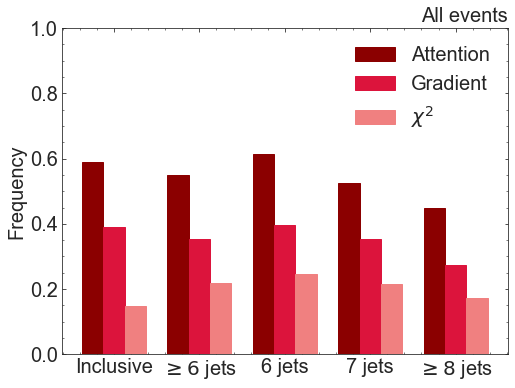

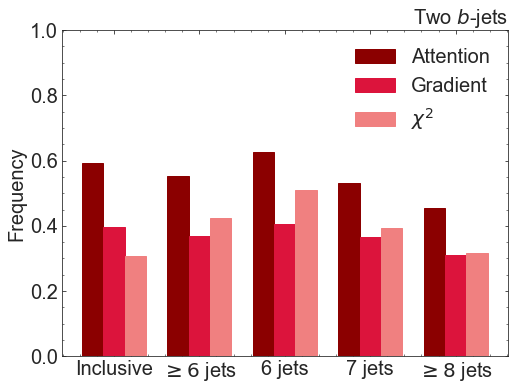

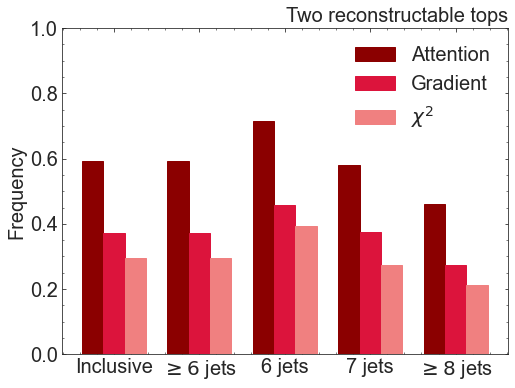

In [25]:
for q in range(3):

    barWidth = 0.25

    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 1) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax0.minorticks_on()

    # set height of bar
    Att = [mycounter[q][0] / denom[q][0],mycounter[q][4] / denom[q][4],mycounter[q][1] / denom[q][1],mycounter[q][2] / denom[q][2],mycounter[q][3] / denom[q][3]]
    Gra = [mycounter2[q][0] / denom2[q][0],mycounter2[q][4] / denom2[q][4],mycounter2[q][1] / denom2[q][1],mycounter2[q][2] / denom2[q][2],mycounter2[q][3] / denom2[q][3]]
    Chi = [mycounter3[q][0] / denom3[q][0],mycounter3[q][4] / denom3[q][4],mycounter3[q][1] / denom3[q][1],mycounter3[q][2] / denom3[q][2],mycounter3[q][3] / denom3[q][3]]

    # Set position of bar on X axis
    br1 = np.arange(len(Att))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    # Make the plot
    plt.bar(br1, Att, color ='darkred', width = barWidth,
            edgecolor ='darkred', label ='Attention')
    plt.bar(br2, Gra, color ='crimson', width = barWidth,
            edgecolor ='crimson', label ='Gradient')
    plt.bar(br3, Chi, color ='lightcoral', width = barWidth,
            edgecolor ='lightcoral', label ='$\chi^2$')

    # Adding Xticks
    #plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
    plt.ylabel('Frequency', fontsize = 20)
    plt.xticks([r + barWidth for r in range(len(Att))],
            ['Inclusive','$\geq 6$ jets', '6 jets', '7 jets','$\geq 8$ jets'], fontsize = 20)

    plt.ylim([0,1])

    plt.legend(fontsize=20,frameon=False)

    if (q==0):
        plt.title("All events",loc="right",fontsize=20)
        #plt.show()
        plt.savefig("inclusive.pdf",bbox_inches='tight')
    if (q==1):
        plt.title("Two $b$-jets",loc="right",fontsize=20)
        #plt.show()
        plt.savefig("twobs.pdf",bbox_inches='tight')
    if (q==2):
        plt.title("Two reconstructable tops",loc="right",fontsize=20)
        #plt.show()
        plt.savefig("reconstructable.pdf",bbox_inches='tight')

In [26]:
ms = []
m12s = []
m23s = []

mbjj = []
mjj = []
for i in range(10000):
    if (abs(test_result['W_decay_pid'][2*i]) > 10) or (abs(test_result['W_decay_pid'][2*i+1]) > 10):
        continue
    myevent = D_test[i]['x']['graph'].x.numpy()

    for j in range(2):
        if (int(test_result['reco_triplet_indices'][i][j][0]) < 0):
            ms+=[-1]
            m12s+=[-1]
            m23s+=[-1]
            continue
        t1a = myevent[int(test_result['reco_triplet_indices'][i][j][0])]
        t1b = myevent[int(test_result['reco_triplet_indices'][i][j][1])]
        t1c = myevent[int(test_result['reco_triplet_indices'][i][j][2])]
        ms+=[mym([t1a,t1b,t1c])]
        m12s+=[mym([t1a,t1b])]
        m23s+=[mym([t1b,t1c])]
            
ms_att = []
m12s_att = []
m23s_att = []
ms_att_miss = []
pT_att_miss = []
eta_att_miss = []
pT_true_miss = []
eta_true_miss = []
for i in range(10000):
    if (abs(test_result['W_decay_pid'][2*i]) > 10) or (abs(test_result['W_decay_pid'][2*i+1]) > 10):
        continue
    myevent = D_test[i]['x']['graph'].x.numpy()

    for j in range(2):
        if (int(test_result_attn_j_only['top_attention_indices'][i][j][0]) < 0):
            ms_att+=[-1]
            m12s_att+=[-1]
            m23s_att+=[-1]
            continue
        t1a = myevent[int(test_result_attn_j_only['top_attention_indices'][i][j][0])]
        t1b = myevent[int(test_result_attn_j_only['top_attention_indices'][i][j][1])]
        t1c = myevent[int(test_result_attn_j_only['top_attention_indices'][i][j][2])]
        ms_att+=[mym([t1a,t1b,t1c])]
        m12s_att+=[mym([t1a,t1b])]
        m23s_att+=[mym([t1b,t1c])]
        
        if (int(test_result['reco_triplet_indices'][i][j][0]) < 0):
            ms_att_miss+=[mym([t1a,t1b,t1c])]
            pT_att_miss+=[mypT([t1a,t1b,t1c])]
            eta_att_miss+=[myeta([t1a,t1b,t1c])]            
            pT_true_miss+=[test_result['y_target'][2*i+j][0]]
            eta_true_miss+=[test_result['y_target'][2*i+j][1]]
        
ms_grad2 = []
m12s_grad2 = []
m23s_grad2 = []
ms_grad2_miss = []
pT_grad2_miss = []
eta_grad2_miss = []
for i in range(10000):
    if (abs(test_result['W_decay_pid'][2*i]) > 10) or (abs(test_result['W_decay_pid'][2*i+1]) > 10):
        continue
    myevent = D_test[i]['x']['graph'].x.numpy()

    for j in range(2):
        if (len(test_result['top_gradient2_indices'][i][j]) < 3):
            ms_grad2+=[-1]
            m12s_grad2+=[-1]
            m23s_grad2+=[-1]
            continue
        t1a = myevent[int(test_result['top_gradient2_indices'][i][j][0])]
        t1b = myevent[int(test_result['top_gradient2_indices'][i][j][1])]
        t1c = myevent[int(test_result['top_gradient2_indices'][i][j][2])]
        ms_grad2+=[mym([t1a,t1b,t1c])]
        m12s_grad2+=[mym([t1a,t1b])]
        m23s_grad2+=[mym([t1b,t1c])]
        
        if (int(test_result['reco_triplet_indices'][i][j][0]) < 0):
            ms_grad2_miss+=[mym([t1a,t1b,t1c])]
            pT_grad2_miss+=[mypT([t1a,t1b,t1c])]
            eta_grad2_miss+=[myeta([t1a,t1b,t1c])]

<ipython-input-13-7da05e9185c5>:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(E**2-px**2-py**2-pz**2)


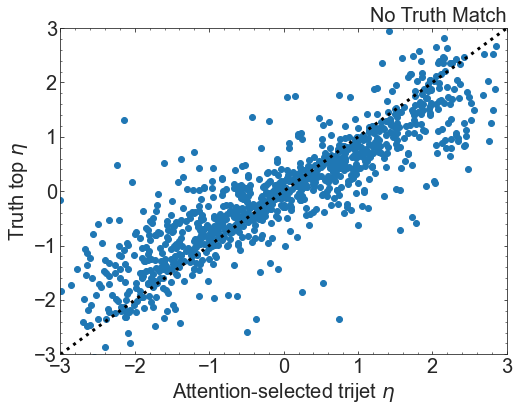

In [27]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.scatter(eta_att_miss[0:1000],eta_true_miss[0:1000])

plt.xlim([-3,3])
plt.ylim([-3,3])
plt.plot([-3,3],[-3,3],color="black",ls=":",lw=3)
plt.xlabel("Attention-selected trijet $\eta$",fontsize=20)
plt.ylabel("Truth top $\eta$",fontsize=20)
plt.title("No Truth Match",fontsize=20,loc="right")
plt.savefig("eta_scatter_attention.pdf",bbox_inches='tight')

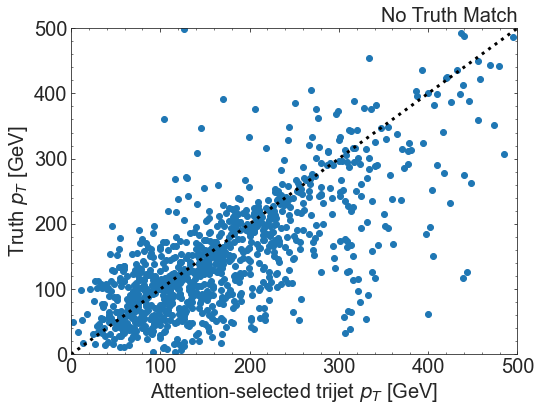

In [28]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.scatter(pT_att_miss[0:1000],pT_true_miss[0:1000])

plt.xlim([0,500])
plt.ylim([0,500])
plt.plot([0,500],[0,500],color="black",ls=":",lw=3)
plt.xlabel("Attention-selected trijet $p_T$ [GeV]",fontsize=20)
plt.ylabel("Truth $p_T$ [GeV]",fontsize=20)
plt.title("No Truth Match",fontsize=20,loc="right")
plt.savefig("pT_scatter_attention.pdf",bbox_inches='tight')

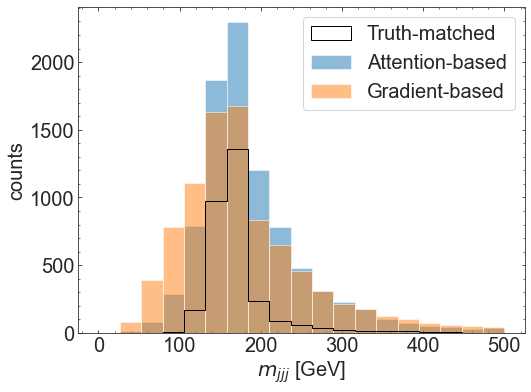

In [29]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(ms,bins=np.linspace(0,500,20),histtype="step",color="black",label="Truth-matched")
plt.hist(ms_att,bins=np.linspace(0,500,20),alpha=0.5,label="Attention-based")
plt.hist(ms_grad2,bins=np.linspace(0,500,20),alpha=0.5,label="Gradient-based")
#plt.hist(ms_grad2,bins=np.linspace(0,500,20),histtype="step",color="black",ls=":",label="Gradient-based 2")
plt.legend(fontsize=20)
plt.xlabel("$m_{jjj}$ [GeV]",fontsize=20)
plt.ylabel("counts",fontsize=20)
#plt.title("No Truth Match",fontsize=20,loc="right")
plt.savefig("mjjj_all.pdf",bbox_inches='tight')

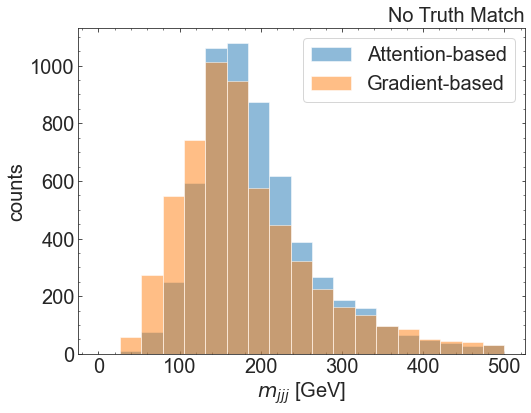

In [30]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(ms_att_miss,bins=np.linspace(0,500,20),alpha=0.5,label="Attention-based")
plt.hist(ms_grad2_miss,bins=np.linspace(0,500,20),alpha=0.5,label="Gradient-based")

plt.legend(fontsize=20)
plt.xlabel("$m_{jjj}$ [GeV]",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.title("No Truth Match",fontsize=20,loc="right")
plt.savefig("mjjj_nomatch.pdf",bbox_inches='tight')